# Libraries, Modules, and Configuration File

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.append('/root/ml_process_feb23/')
import src.util as utils
config = utils.load_config()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
 
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing


Prepare the datasets.


In [20]:
# Rename the train dataset
df_train = utils.pkl_load(config["dataset_EDA_path"])
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

# Concatenate the x_valid and y_valid for preprocessing
x_valid = utils.pkl_load(config["dataset_valid_path"][0])
y_valid = utils.pkl_load(config["dataset_valid_path"][1])
df_valid = pd.concat([x_valid, y_valid], axis=1).reset_index(drop=True)
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

# Concatenate the x_test and y_test for preprocessing
x_test = utils.pkl_load(config["dataset_test_path"][0])
y_test = utils.pkl_load(config["dataset_test_path"][1])
df_test = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])


## Data Transformation

For the data with an extensive range, I will transform them to squeeze the range so the distribution will get near to a normal distribution than a skewed one.

The features that need to be transformed are: `income`, `expenditure`, and `months`.


In [4]:
# Group of features to be transformed
config["cols_to_log"]

['income', 'expenditure', 'months']

In [5]:
# Create the function for data visualization.
def draw_histograms(data, 
                    features, 
                    n_rows, 
                    n_cols, 
                    bins):
    """A function to visualize the multiple graphs of the features
    for an introductory observation to the dataset"""
    fig = plt.figure()
    for i, var_name in enumerate(features):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        data[var_name].hist(bins = bins, ax=ax, color = 'green', figsize = (50, 50))
        ax.set_title(var_name, fontsize = 50)
        ax.tick_params(labelsize = 40, grid_alpha = 0.7)
    fig.tight_layout() 
    plt.show()

In [21]:
# Create the function for data transformation
def cols_transform(dataset):
    """A function to transform the feature(s) value in the dataset into logarithmic value.
    The defined features are transformed and appended to the dataset,
    after the transformation and appendment of all features are done
    the features with original value are dropped from the dataset"""

    log_cols = []
    for i in range (len(config["cols_to_log"])):
        col = config["cols_to_log"][i]
        transformed = col + "_log" 
        dataset[transformed] = np.log10(dataset[col]+1)
        
        log_cols.append(transformed)
    dataset.drop(config["cols_to_log"], axis = 1, inplace = True)
    return log_cols

### Training Data


The histogram plots before transformation


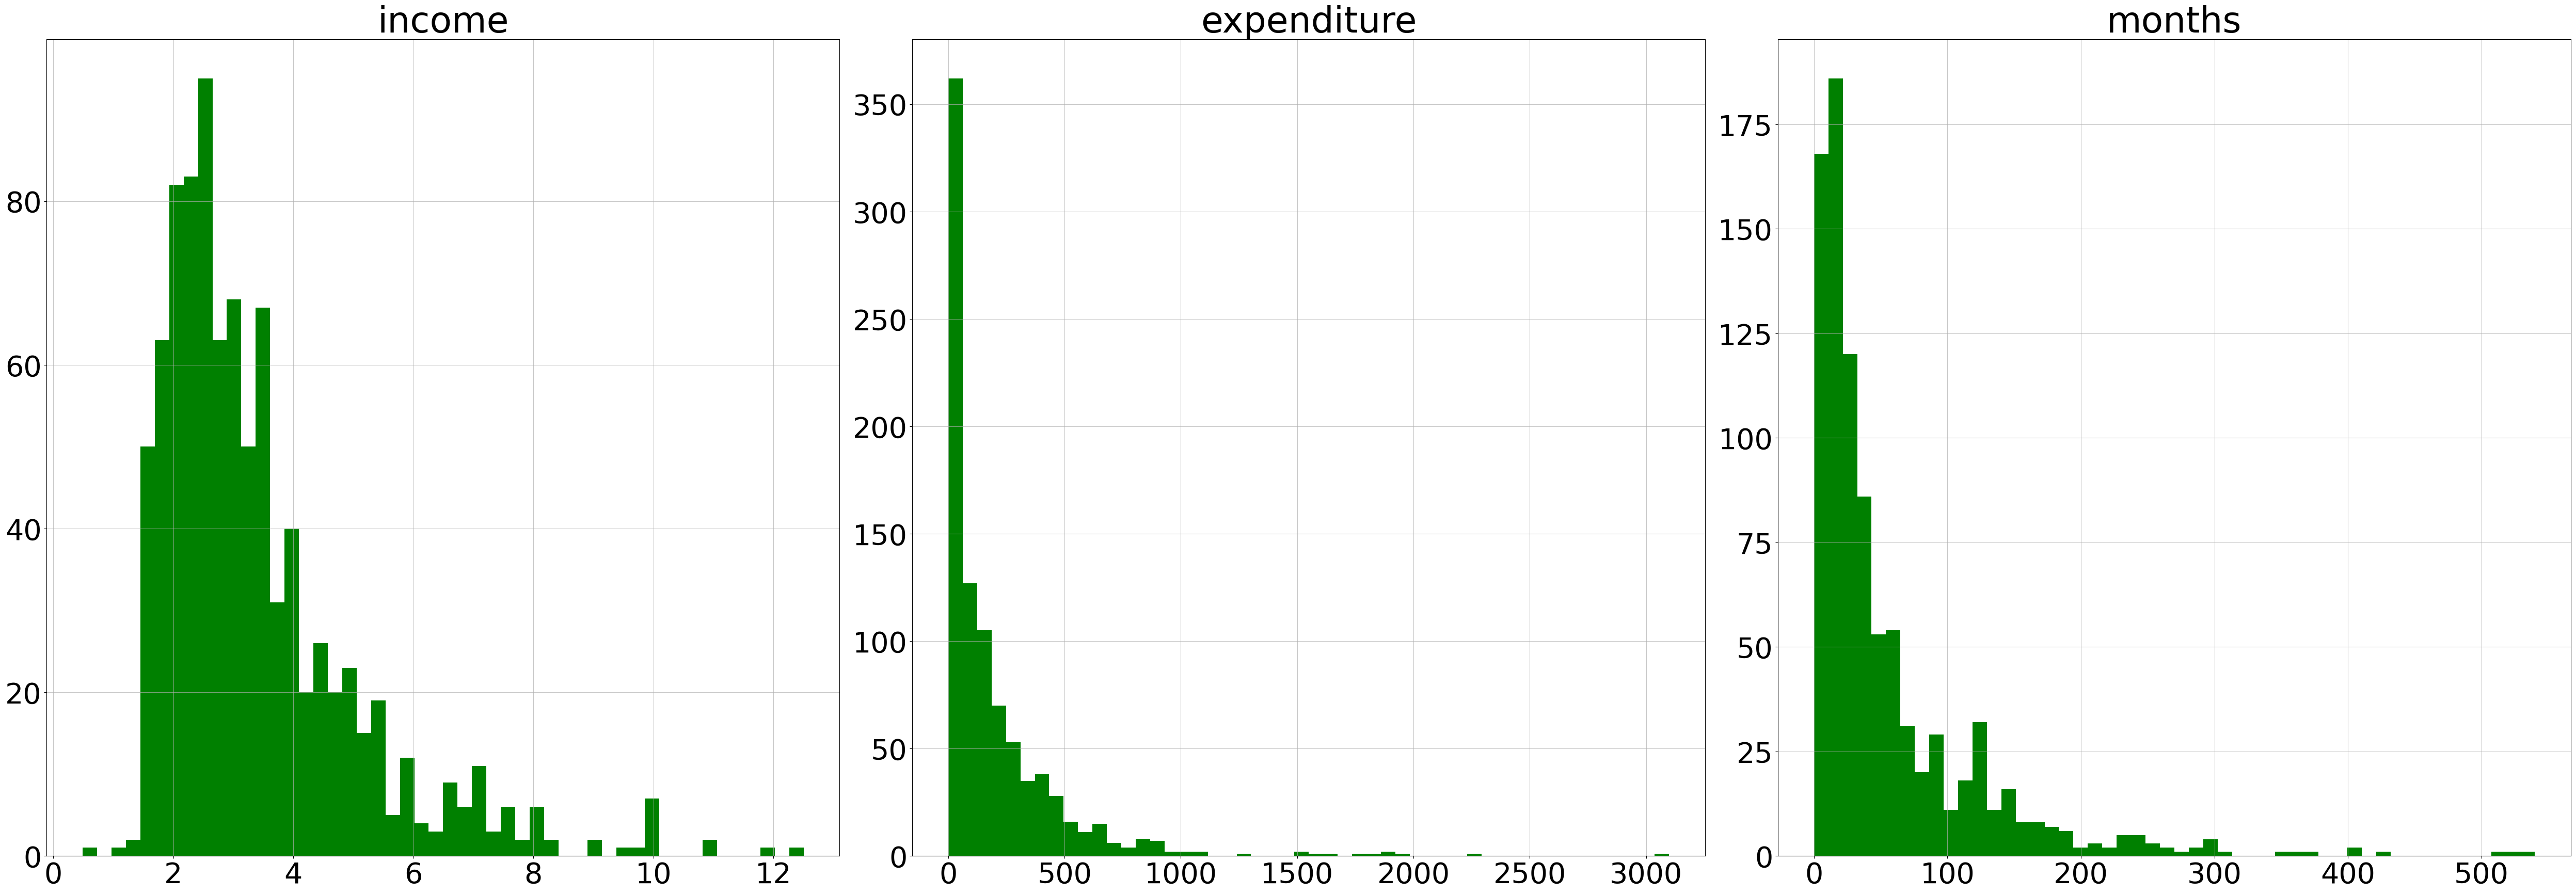

In [10]:
print("The histogram plots before transformation")
draw_histograms(df_train, config["cols_to_log"], 3, 3, 50)


In [22]:
# Execute the transformation function
log_cols = cols_transform(df_train)

In [23]:
# Recheck the dataframe columns after transformation
df_train.columns

Index(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'card', 'income_log', 'expenditure_log',
       'months_log'],
      dtype='object')

In [24]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

The histogram plots of the transformed features


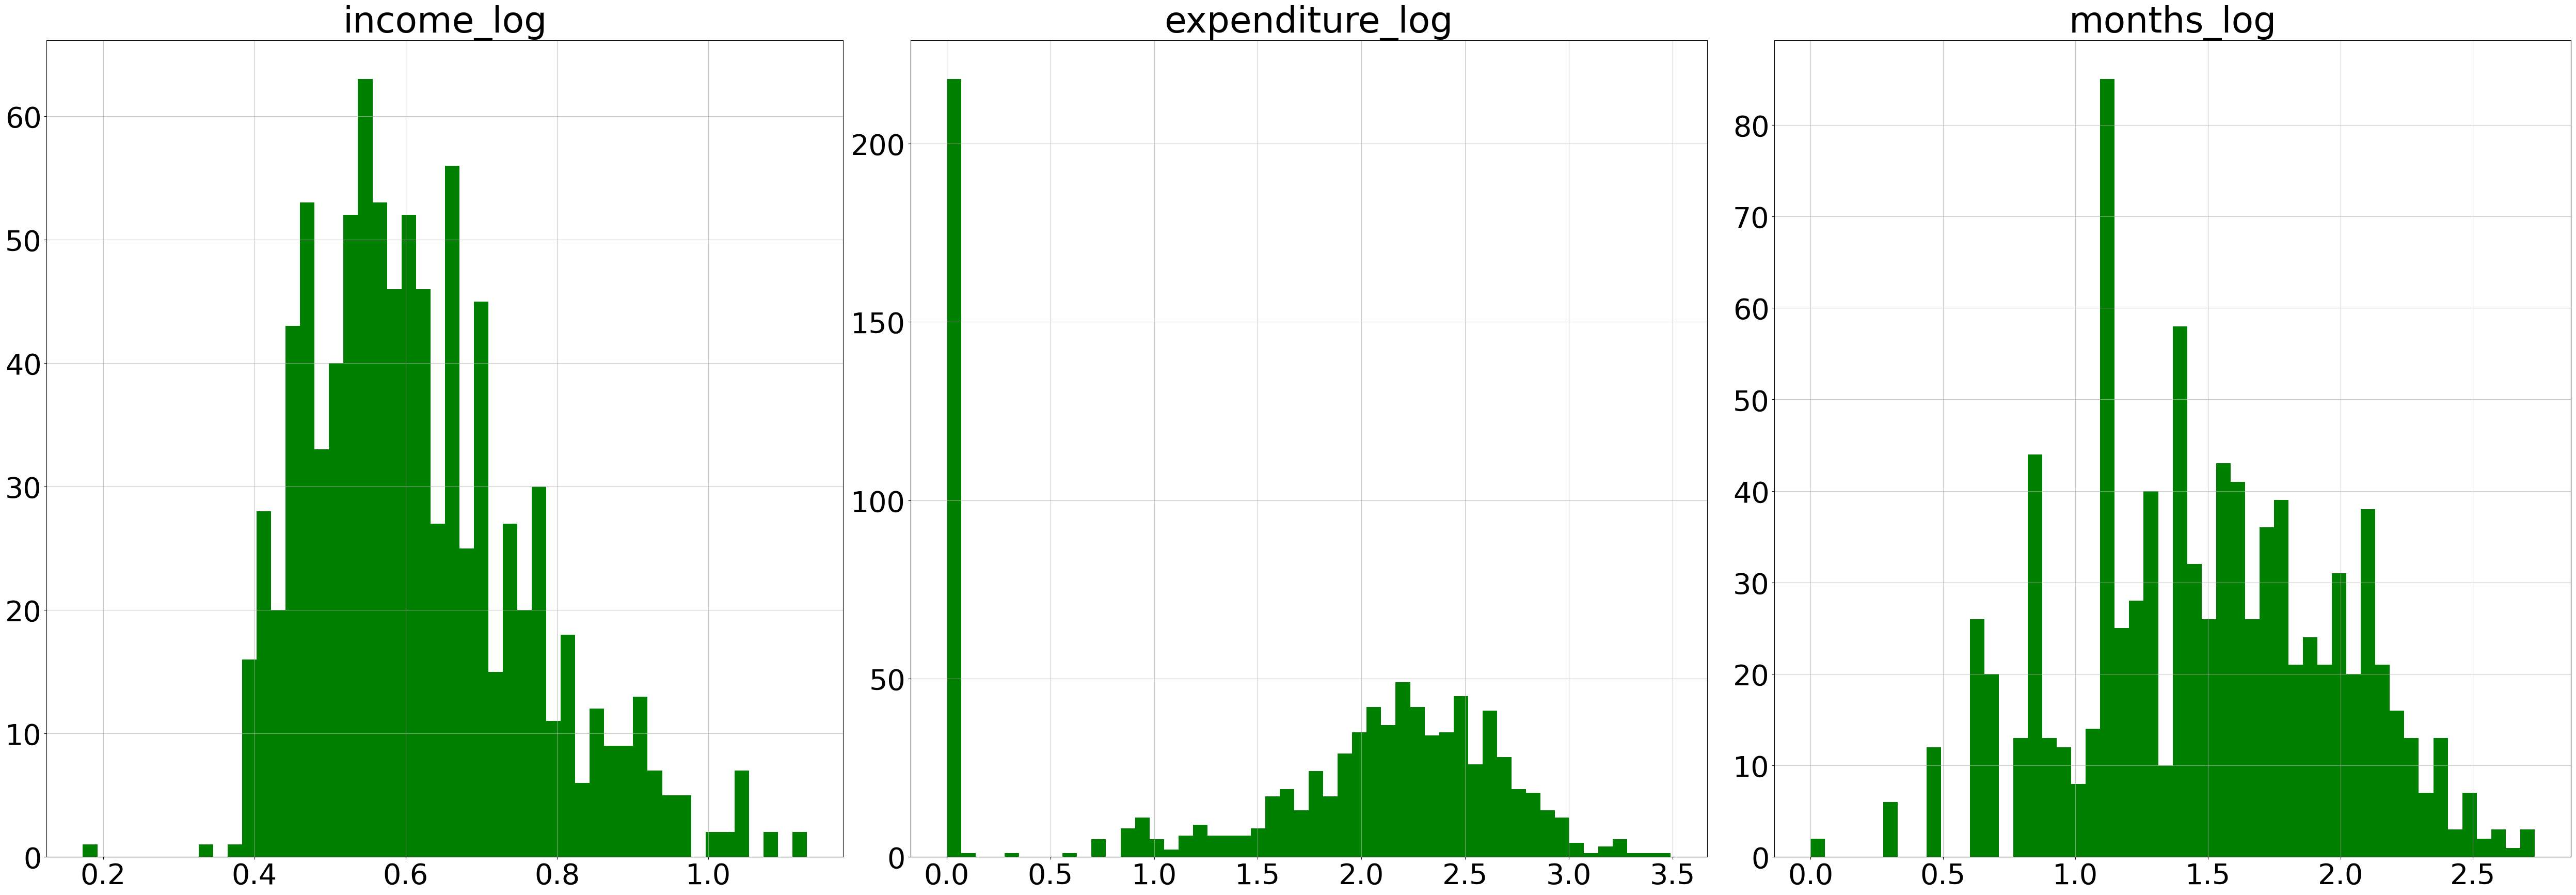

In [25]:
print("The histogram plots of the transformed features")
draw_histograms(df_train, log_cols, 3, 3, 50)

### Validation Data


The histogram plots before transformation


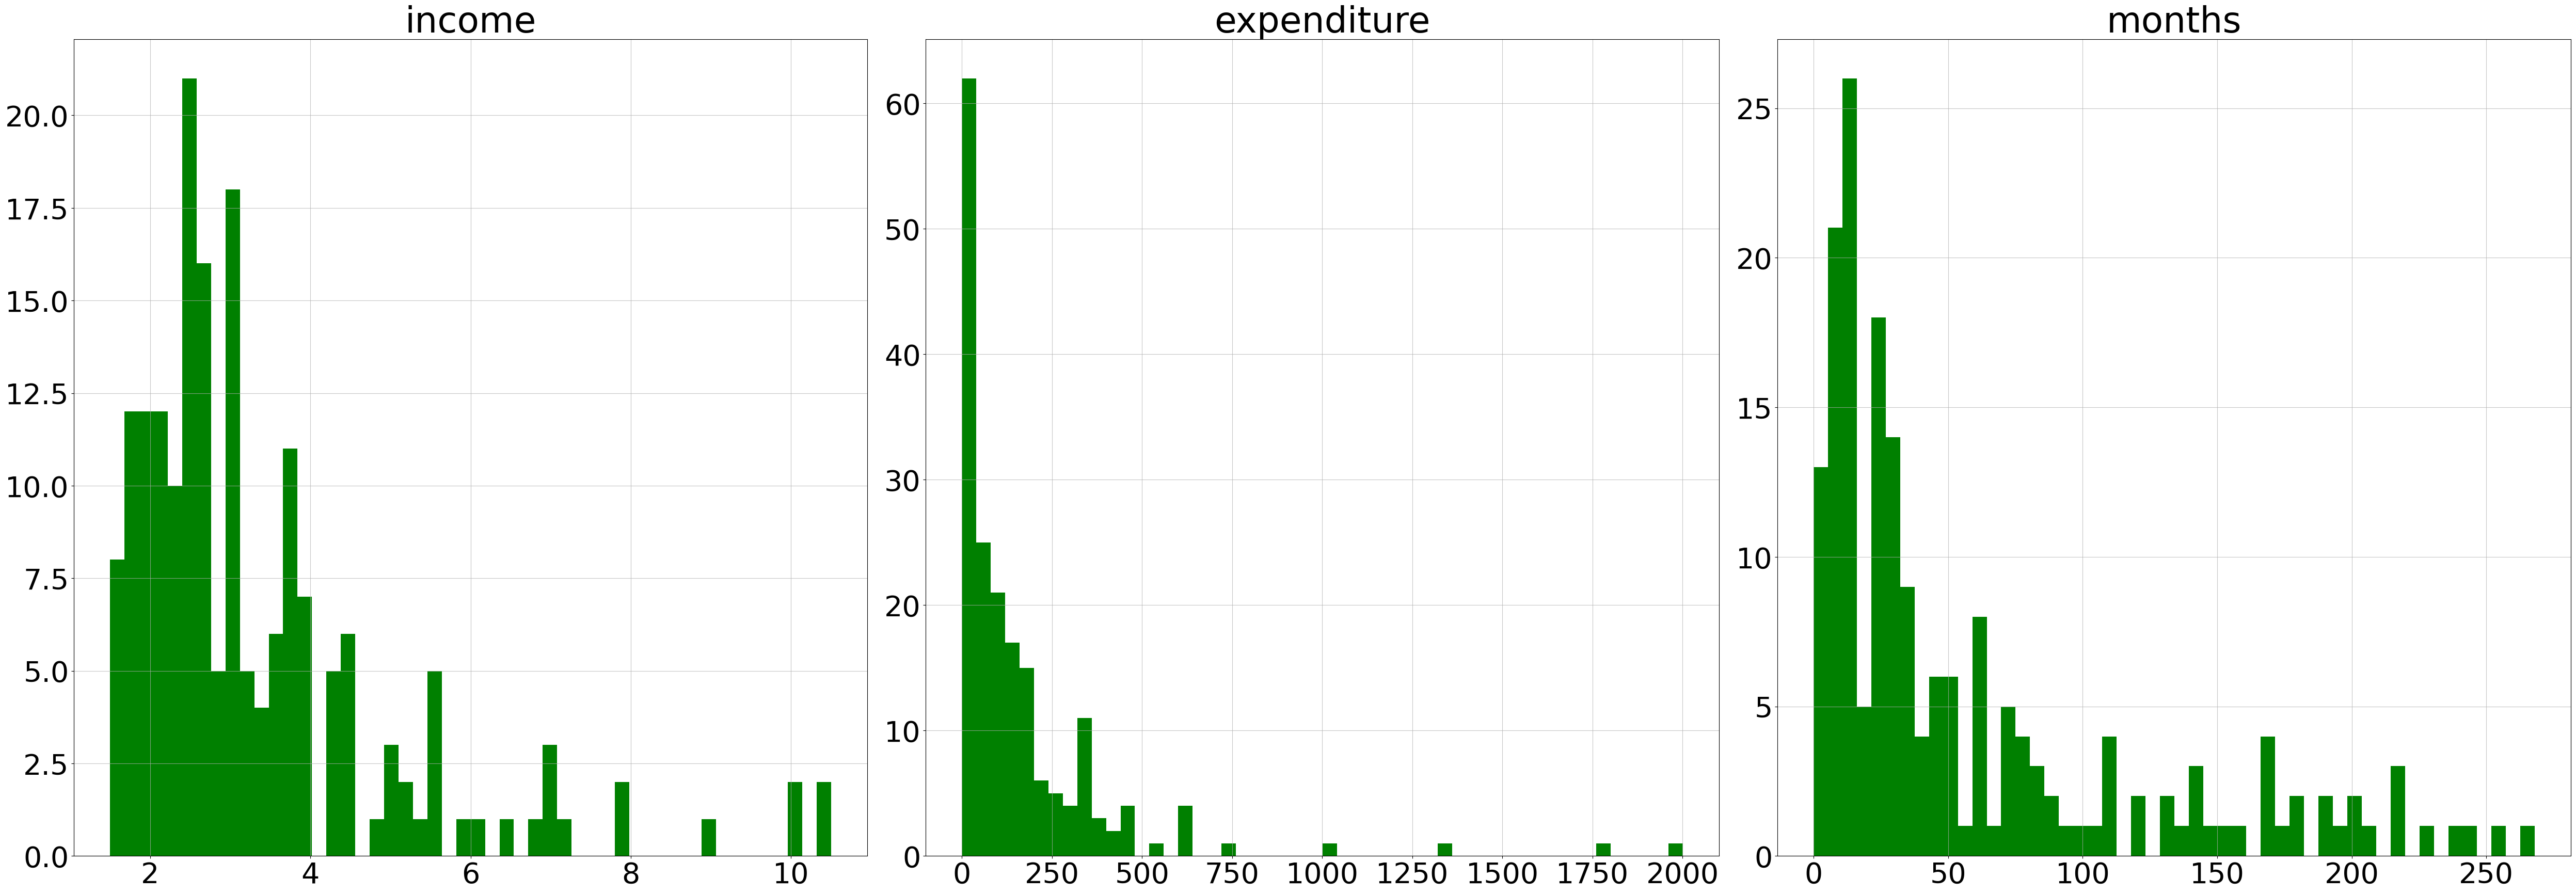

In [26]:
print("The histogram plots before transformation")
draw_histograms(df_valid, config["cols_to_log"], 3, 3, 50)

In [27]:
# Execute the transformation function
log_cols = cols_transform(df_valid)

In [28]:
# Recheck the dataframe columns after transformation
df_valid.columns

Index(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'card', 'income_log', 'expenditure_log',
       'months_log'],
      dtype='object')

In [29]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][1])

The histogram plots of the transformed features


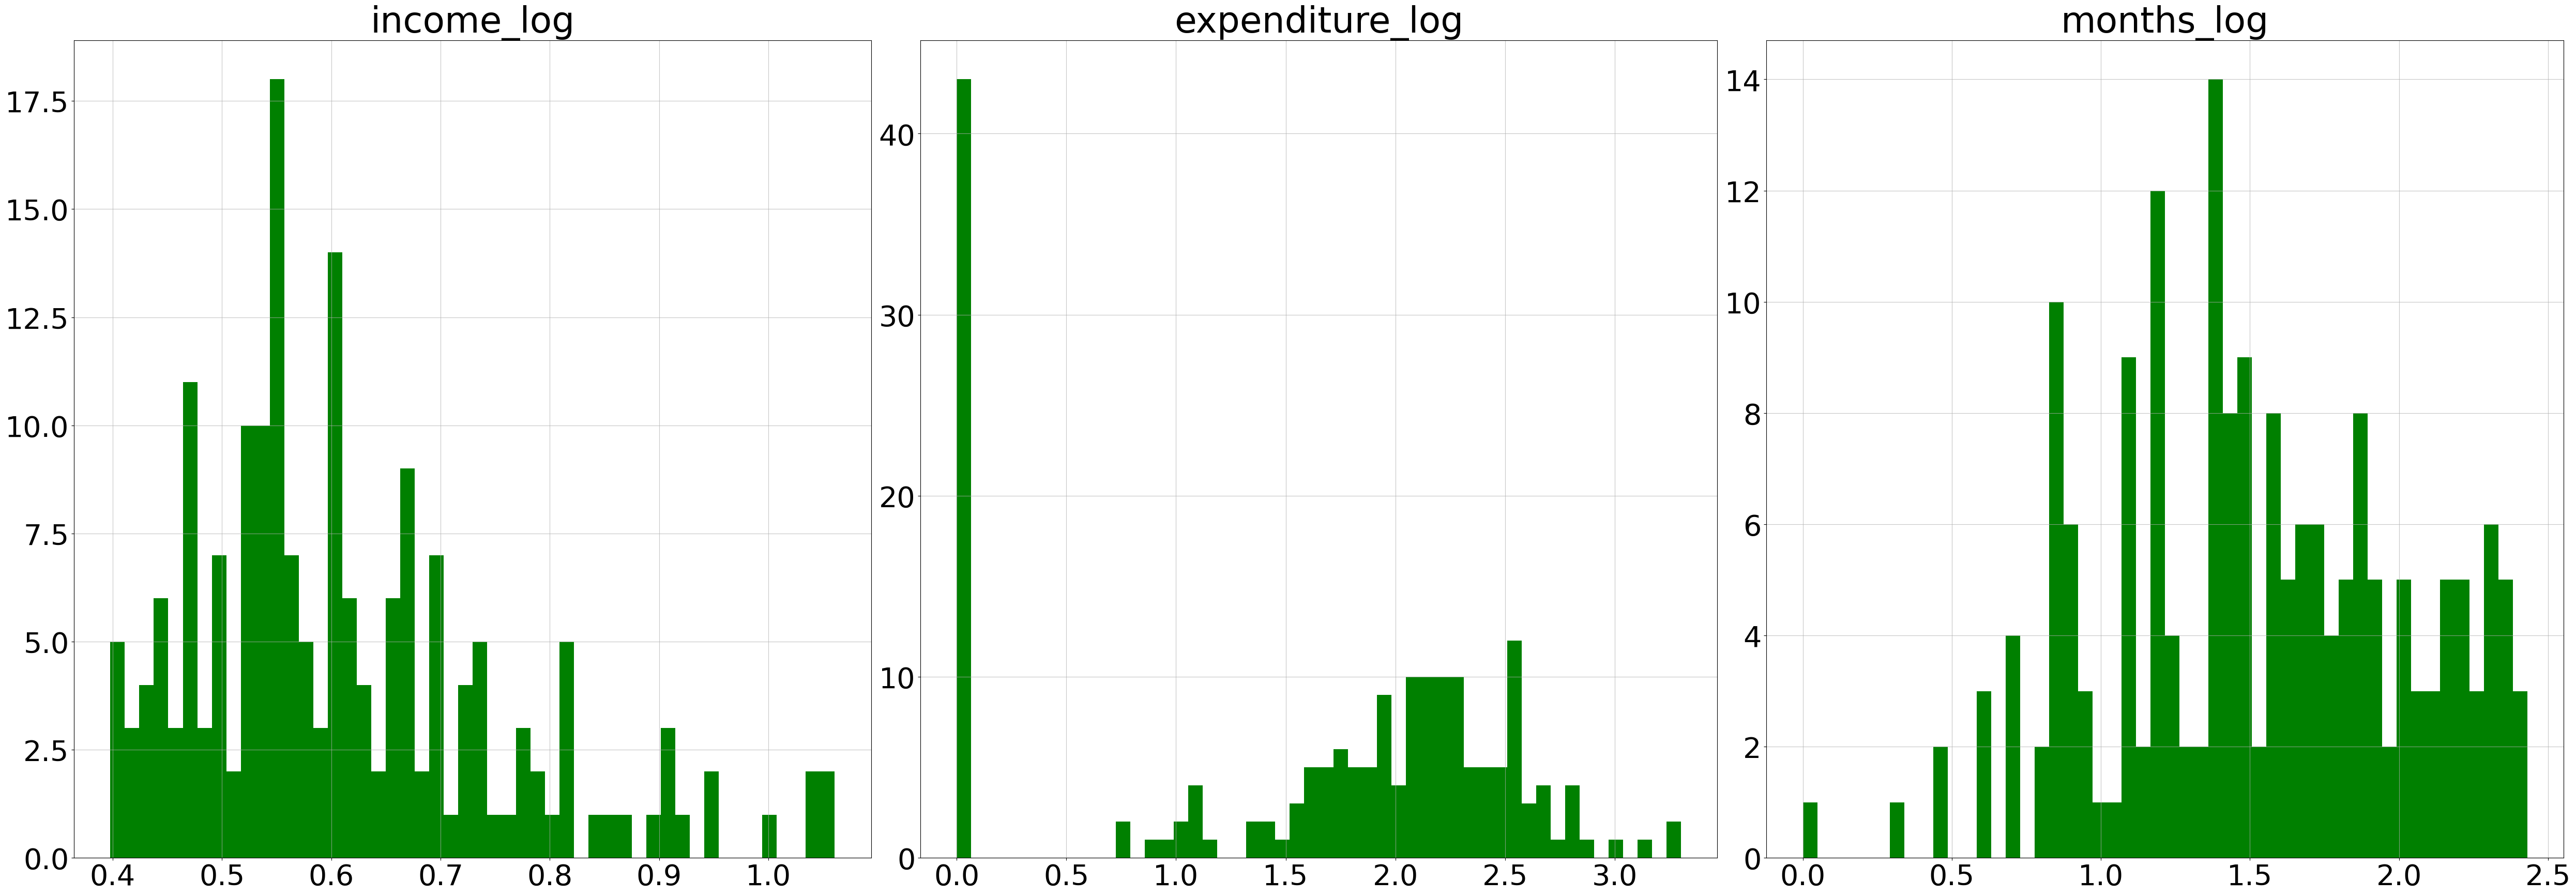

In [30]:
print("The histogram plots of the transformed features")
draw_histograms(df_valid, config["log_cols"], 3, 3, 50)


### Testing Data

The histogram plots before transformation


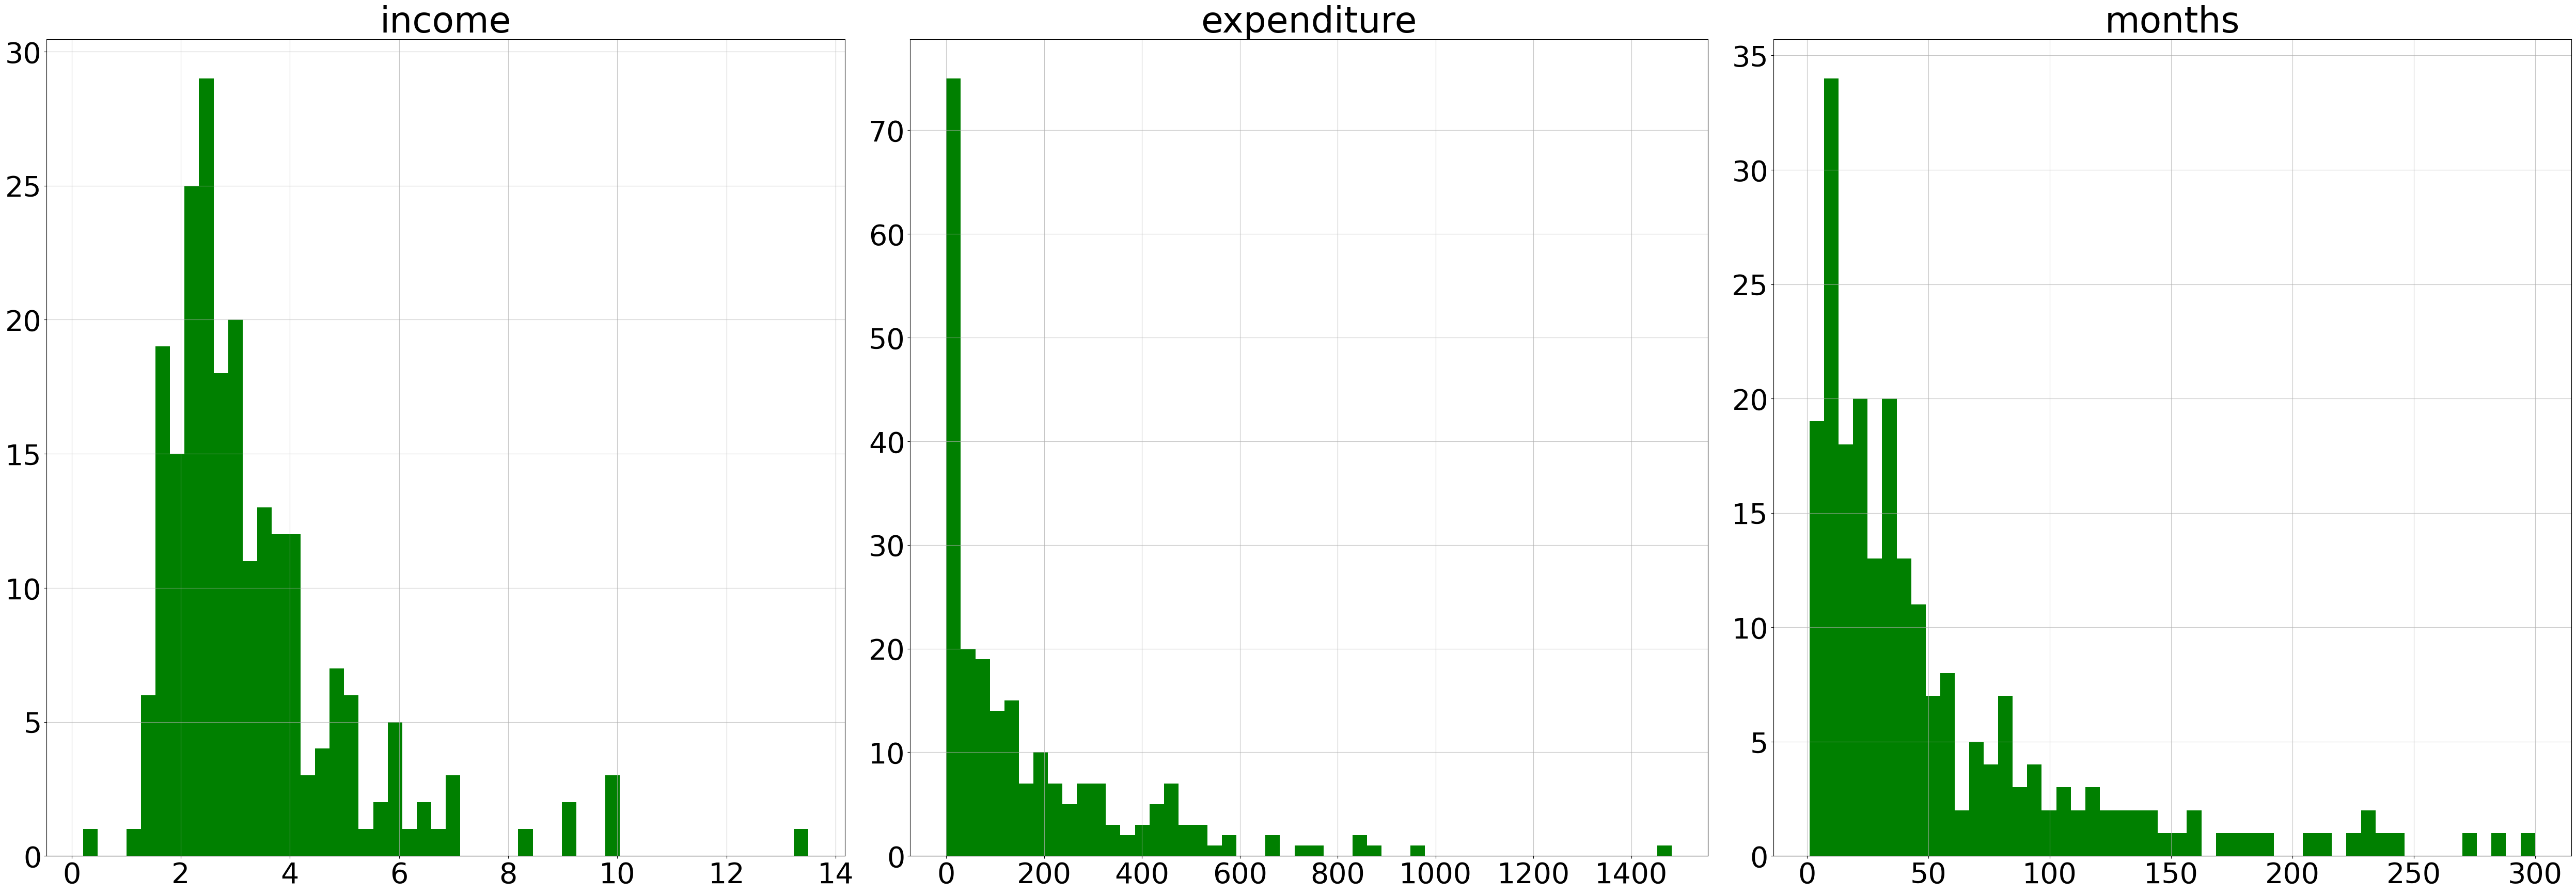

In [31]:
print("The histogram plots before transformation")
draw_histograms(df_test, config["cols_to_log"], 3, 3, 50)

In [32]:
# Execute the transformation function
log_cols = cols_transform(df_test)

In [33]:
# Recheck the dataframe columns after transformation
df_test.columns

Index(['reports', 'age', 'share', 'owner', 'selfemp', 'dependents',
       'majorcards', 'active', 'card', 'income_log', 'expenditure_log',
       'months_log'],
      dtype='object')

In [34]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][2])

The histogram plots of the transformed features


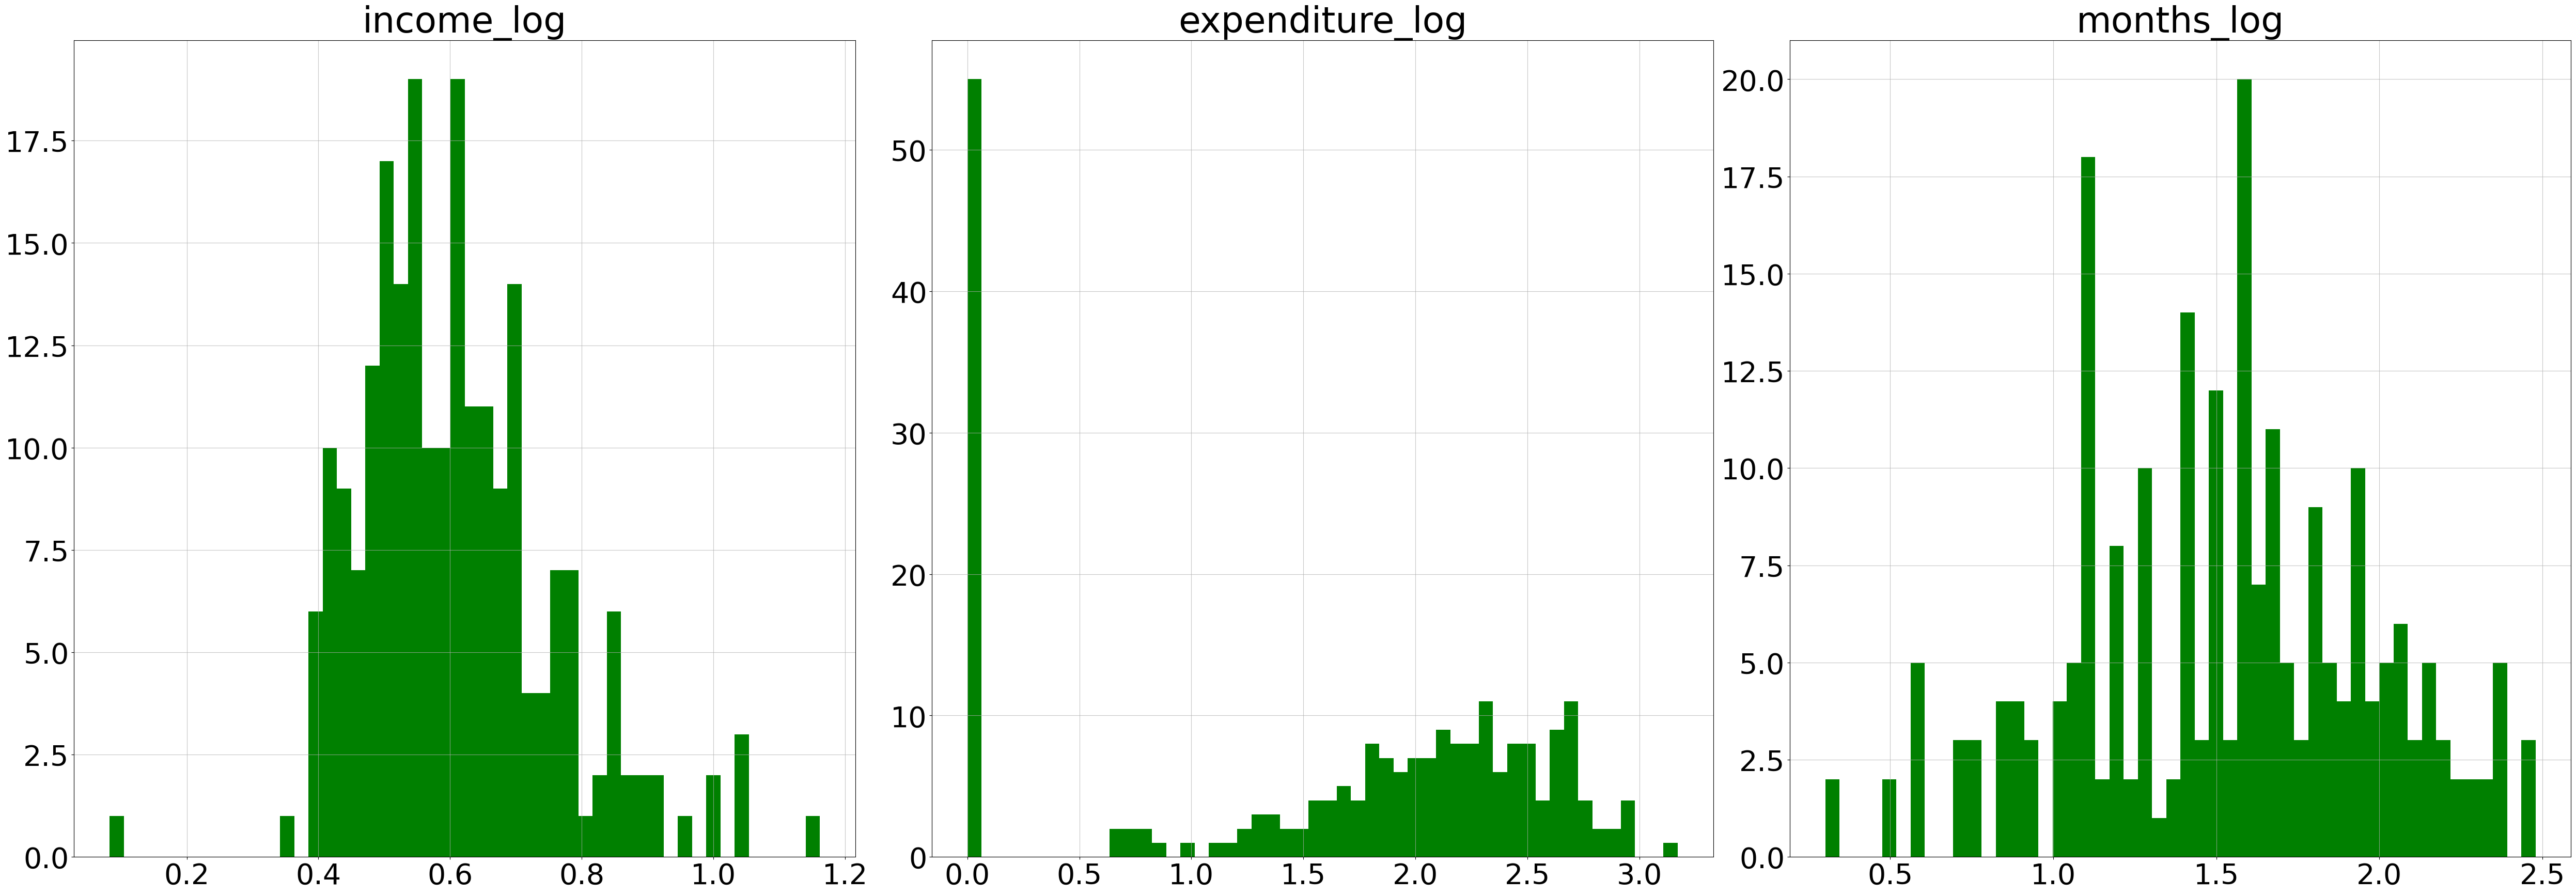

In [35]:
print("The histogram plots of the transformed features")
draw_histograms(df_test, log_cols, 3, 3, 50)

## Label Encoding

Convert the values of categorical features into numeric ones.

The features are: `owner`, `selfemp`, and `card`.

The encoded result value are 0 (zero) for "no", and 1 for "yes".

Let's first check the columns:

In [36]:
categorical_columns = config["cat_columns"]
print(f"The Original Categorical Columns:\n{df_train[categorical_columns].tail()}\n")
print("-------------------------------------\n")
df_train[categorical_columns].info()


The Original Categorical Columns:
    owner selfemp card
898    no      no  yes
899    no      no   no
900    no      no  yes
901   yes     yes  yes
902   yes      no   no

-------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   owner    903 non-null    object
 1   selfemp  903 non-null    object
 2   card     903 non-null    object
dtypes: object(3)
memory usage: 21.3+ KB


In [37]:
# Create function to encode the categorical columns
def label_encoding(dataset):
    """A function to convert the categorical values into the numeric ones.
    The list of categorical features are encoded by .map function,
    returning a dataset with the features encoded."""
    for i in range (len(config["cat_columns"])):
        col = config["cat_columns"][i]
        dataset[col] = dataset[col].map({'yes':1, 'no':0})
    return dataset

### Training Data

In [38]:
# Execute the label encoding function
df_train = label_encoding(df_train)

In [39]:
print(f"The Encoded Categorical Columns:\n{df_train[categorical_columns].tail()}\n")
print("-------------------------------------\n")
df_train[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
898      0        0     1
899      0        0     0
900      0        0     1
901      1        1     1
902      1        0     0

-------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    903 non-null    int64
 1   selfemp  903 non-null    int64
 2   card     903 non-null    int64
dtypes: int64(3)
memory usage: 21.3 KB


In [40]:
# Save as pickle file
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

### Validation Data

In [41]:
# Execute the label encoding function
df_valid = label_encoding(df_valid)

In [42]:
print(f"The Encoded Categorical Columns:\n{df_valid[categorical_columns].tail()}\n")
print("-------------------------------------\n")
df_valid[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
180      1        0     1
181      0        0     1
182      0        0     1
183      0        0     0
184      0        0     1

-------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    185 non-null    int64
 1   selfemp  185 non-null    int64
 2   card     185 non-null    int64
dtypes: int64(3)
memory usage: 4.5 KB


In [43]:
# Save as pickle file
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

### Testing Data

In [44]:
# Execute the label encoding function
df_test = label_encoding(df_test)

In [45]:
print(f"The Encoded Categorical Columns:\n{df_test[categorical_columns].tail()}\n")
print("-------------------------------------\n")
df_test[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
219      0        0     1
220      1        1     1
221      1        0     1
222      1        0     1
223      0        0     1

-------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    224 non-null    int64
 1   selfemp  224 non-null    int64
 2   card     224 non-null    int64
dtypes: int64(3)
memory usage: 5.4 KB


In [46]:
# Save as pickle file
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

## Data Binning

The data binning process is useful to smoothen the data, it replaces values contained into a small interval with a single representative value for that interval, in order to improves the model accuracy.

In [51]:
# Create the function for data binning
def binning(dataset, col, bins, labels):
    """A function for categorize the feature's value in the col parameter into groups with specific interval defined in the bins parameter.
    Creates a new feature contains the value defined in the labels parameter."""
    
    binned = col +"_bin"
    dataset[binned] = pd.cut(dataset[col] , bins=bins, labels=labels, include_lowest=True).astype(int)
    return dataset

The features that suitable to be binned are: `age`, `reports`, `dependents`, and `active`.

### `age`

The age groups are divide based on the classification from FICO, source: [Age group for credit scoring](https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/)

The category definition of this feature are:
+ 1: 18 - 24 years old
+ 2: 25 - 40 years old
+ 3: 41 - 56 years old
+ 4: 57 - 75 years old
+ 5: more than 75 years old 

In [52]:
# Create the instance for the value boundary for each category
bins = [18, 24, 40, 56, 75, 99]

# Create the instance for age category labels
labels = [1, 2, 3, 4, 5]

#### Training Data

count    903.000000
mean      33.228313
std        9.955114
min       18.166670
25%       25.250000
50%       31.500000
75%       38.916670
max       83.500000
Name: age, dtype: float64
Median: 31.5


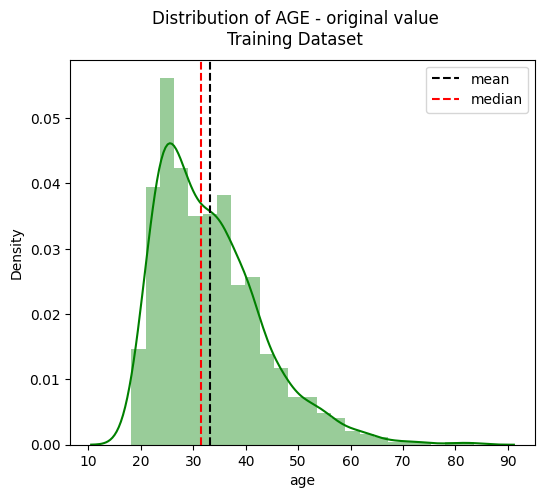

In [53]:
# Print the statistical information and histogram plot before data binning
x = df_train['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [54]:
# Execute the binning function
df_train = binning(df_train, 'age', config["bins_age"], config["labels_age"])

# Check the binning result and compare it with the original `age` value
df_train[['age', 'age_bin']].tail(10)

,age,age_bin
893,25.25000,2
894,26.08333,2
895,45.58333,3
896,32.58333,2
897,29.50000,2
898,35.83333,2
899,29.16667,2
900,29.41667,2
901,61.08333,4
902,27.33333,2


count    903.000000
mean       2.077519
std        0.697297
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: age_bin, dtype: float64
Median: 2.0


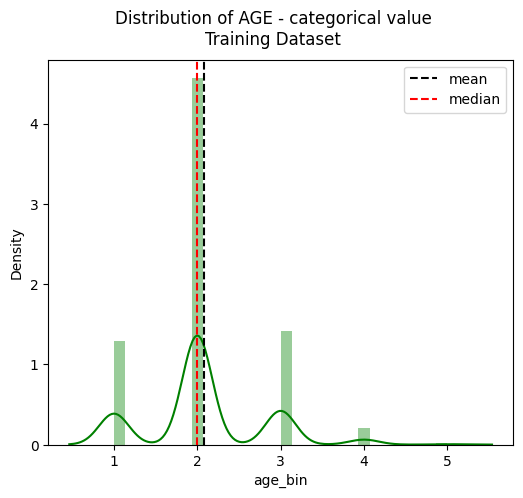

In [55]:
# Print the statistical information and histogram plot after data binning
x = df_train['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [56]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean      34.045946
std        9.915162
min       19.166670
25%       25.833330
50%       31.500000
75%       40.750000
max       65.916660
Name: age, dtype: float64
Median: 31.5


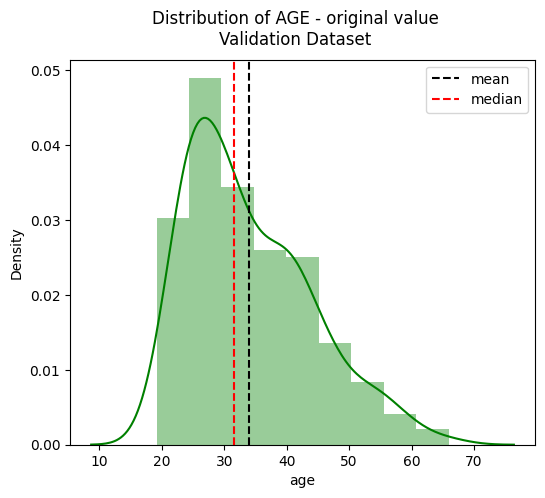

In [57]:
# Print the statistical information and histogram plot before data binning
  
x = df_valid['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [58]:
# Execute the binning function
df_valid = binning(df_valid, 'age', config["bins_age"], config["labels_age"])

# Check the binning result and compare it with the original `age` value
df_valid[['age', 'age_bin']].tail(10)

,age,age_bin
175,25.91667,2
176,28.50000,2
177,23.33333,1
178,54.41667,3
179,39.33333,2
180,43.83333,3
181,26.58333,2
182,26.66667,2
183,25.91667,2
184,23.83333,1


count    185.000000
mean       2.172973
std        0.685505
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: age_bin, dtype: float64
Median: 2.0


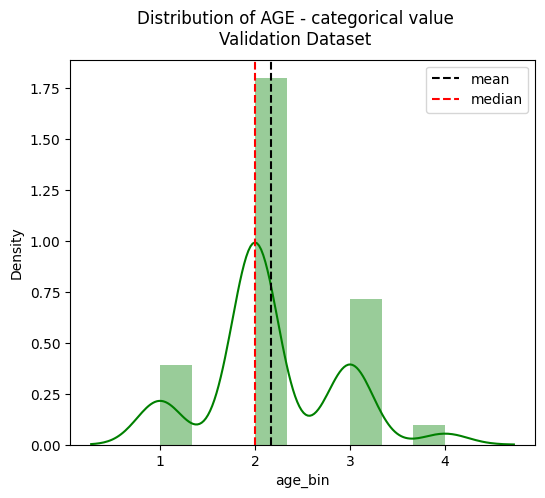

In [59]:
# Print the statistical information and histogram plot after data binning
x = df_valid['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [60]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

count    224.000000
mean      33.484747
std        9.586733
min       19.000000
25%       26.062497
50%       30.666665
75%       40.020832
max       63.750000
Name: age, dtype: float64
Median: 30.666665000000002


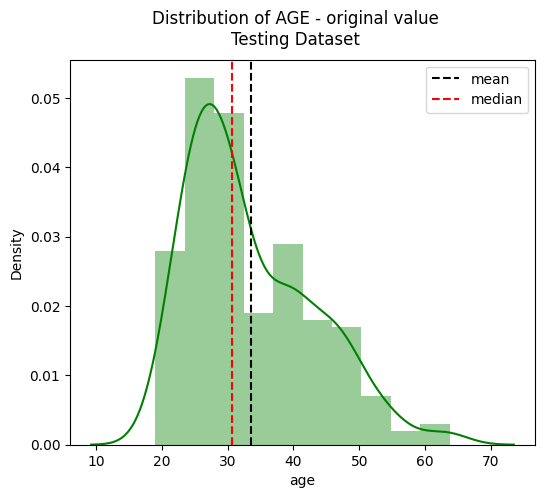

In [61]:
# Print the statistical information and histogram plot before data binning
  
x = df_test['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [62]:
# Execute the binning function
df_test = binning(df_test, 'age', config["bins_age"], config["labels_age"])

# Check the binning result and compare it with the original `age` value
df_test[['age', 'age_bin']].tail(10)

,age,age_bin
214,38.75000,2
215,63.41667,4
216,23.25000,1
217,25.25000,2
218,24.58333,2
219,62.50000,4
220,44.08333,3
221,31.33333,2
222,47.00000,3
223,26.08333,2


count    224.000000
mean       2.133929
std        0.649188
min        1.000000
25%        2.000000
50%        2.000000
75%        2.250000
max        4.000000
Name: age_bin, dtype: float64
Median: 2.0


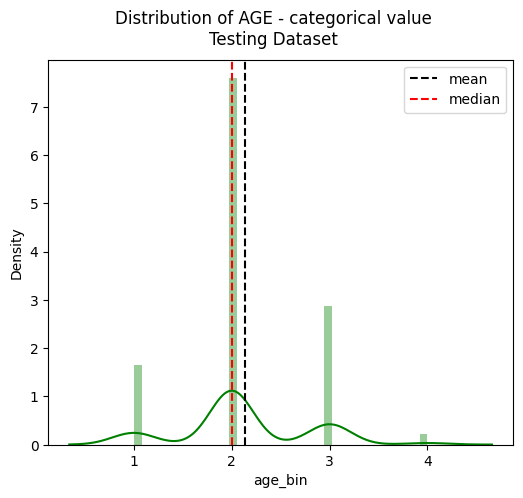

In [63]:
# Print the statistical information and histogram plot after data binning
x = df_test['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [64]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

### `reports`

The category definition of this feature are:
+ 0: zero major derogatory report, "clean record"
+ 1: 1 - 2 major derogatory reports
+ 2: 3 or more major derogatory report, "bad record"

In [65]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 2, 14]

# Create the instance for `reports` category labels
labels = [0, 1, 2]

#### Training Data

count    903.000000
mean       0.449612
std        1.396645
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       14.000000
Name: reports, dtype: float64
Median: 0.0


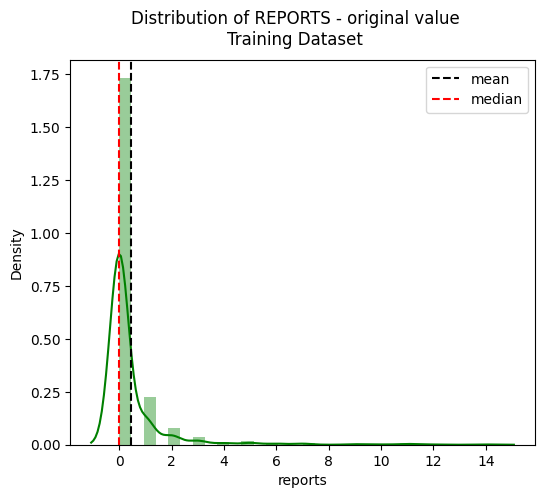

In [66]:
# Print the statistical information and histogram plot before data binning
x = df_train['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [67]:
# Execute the binning function
df_train = binning(df_train, 'reports', config["bins_reports"], config["labels_reports"])

# Check the binning result and compare it with the original `reports` value
df_train[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
893,0,0
894,0,0
895,0,0
896,2,1
897,7,2
898,0,0
899,0,0
900,0,0
901,0,0
902,3,2


count    903.000000
mean       0.240310
std        0.529457
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


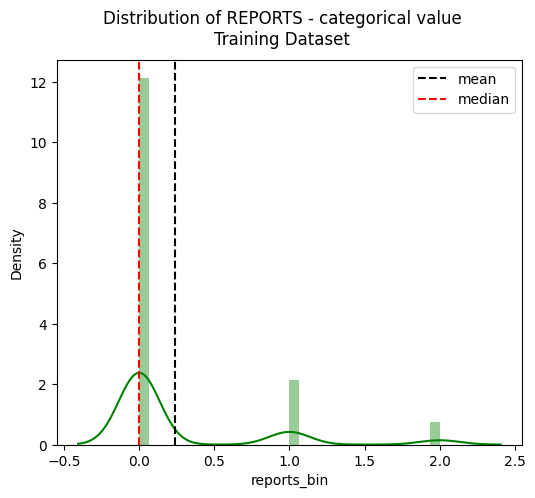

In [68]:
# Print the statistical information and histogram plot after data binning
x = df_train['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [69]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean       0.394595
std        1.037856
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.000000
Name: reports, dtype: float64
Median: 0.0


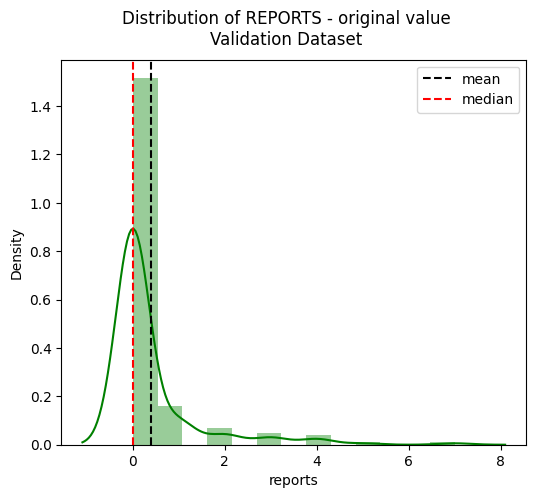

In [70]:
# Print the statistical information and histogram plot before data binning
x = df_valid['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [71]:
# Execute the binning function
df_valid = binning(df_valid, 'reports', config["bins_reports"], config["labels_reports"])

# Check the binning result and compare it with the original `reports` value
df_valid[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
175,0,0
176,1,1
177,0,0
178,0,0
179,0,0
180,0,0
181,2,1
182,0,0
183,2,1
184,0,0


count    185.000000
mean       0.243243
std        0.551943
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


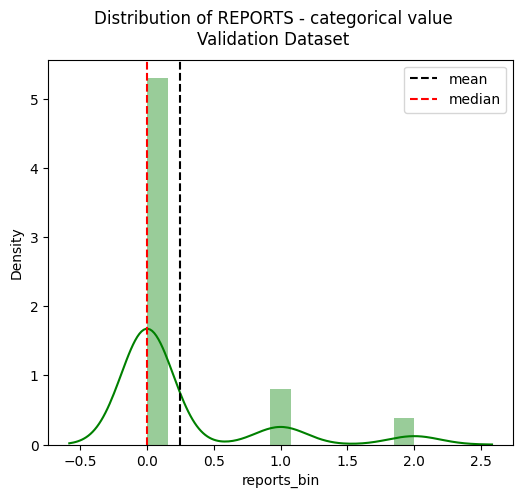

In [72]:
# Print the statistical information and histogram plot after data binning
x = df_valid['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [73]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

count    224.000000
mean       0.544643
std        1.378167
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       11.000000
Name: reports, dtype: float64
Median: 0.0


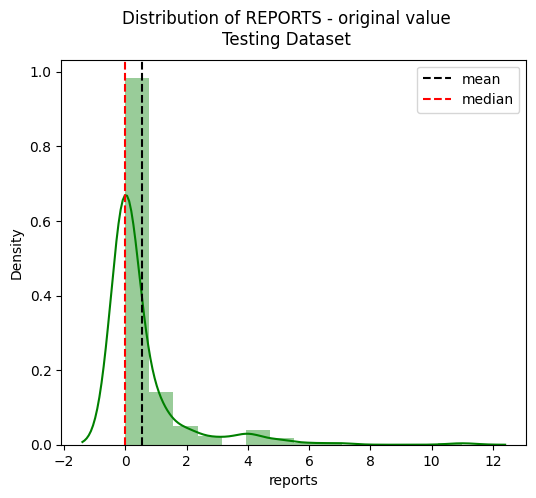

In [74]:
# Print the statistical information and histogram plot before data binning
x = df_test['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [75]:
# Execute the binning function
df_test = binning(df_test, 'reports', config["bins_reports"], config["labels_reports"])

# Check the binning result and compare it with the original `reports` value
df_test[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
214,3,2
215,1,1
216,0,0
217,1,1
218,0,0
219,0,0
220,0,0
221,0,0
222,1,1
223,0,0


count    224.000000
mean       0.303571
std        0.604012
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


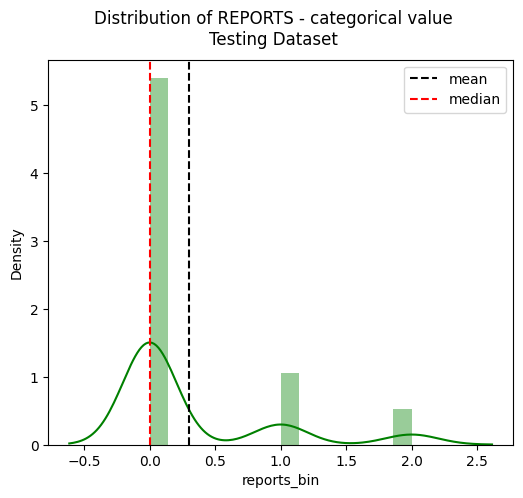

In [76]:
# Print the statistical information and histogram plot after data binning
x = df_test['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [77]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

### `dependents`

For this feature, I categorize by the applicant's marital status and the number of children they have.

The category definition of this feature are:
+ 0: marital status is "single"
+ 1: married, without a child
+ 2: married with 1 or 2 children, "small family" 
+ 3: married with 3 or more children, "big family"



In [78]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 1.99, 3, 6]

# Create the instance for `reports` category labels
labels = [0, 1, 2, 3]

#### Training Data

count    903.000000
mean       1.006645
std        1.282649
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


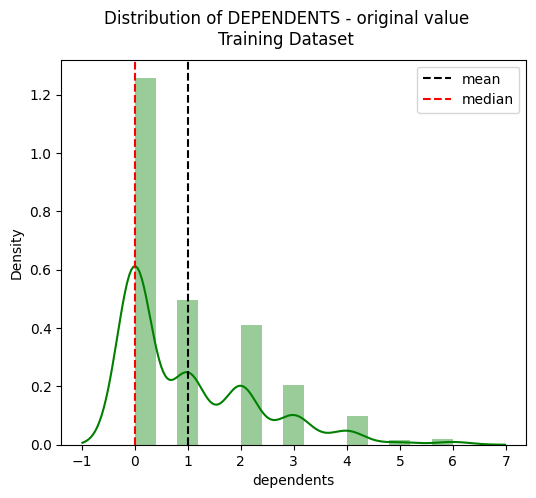

In [79]:
# Print the statistical information and histogram plot before data binning
x = df_train['dependents']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of DEPENDENTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [80]:
# Execute the binning function
df_train = binning(df_train, 'dependents', config["bins_dependents"], config["labels_dependents"])

# Check the binning result and compare it with the original `dependents` value
df_train[['dependents', 'dependents_bin']].tail(10)

,dependents,dependents_bin
893,0,0
894,2,2
895,2,2
896,1,1
897,2,2
898,1,1
899,1,1
900,0,0
901,0,0
902,2,2


count    903.000000
mean       0.849391
std        0.969329
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 0.0


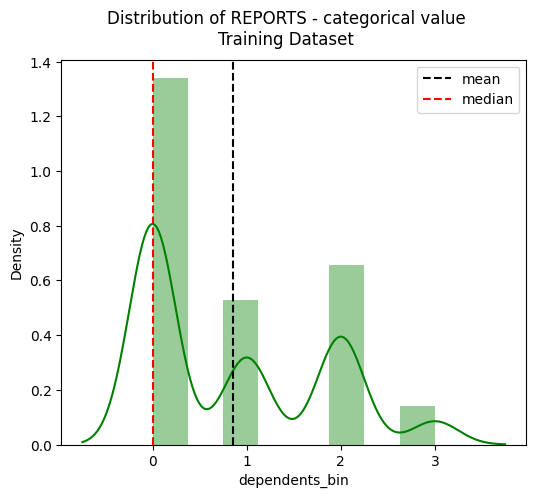

In [81]:
# Print the statistical information and histogram plot after data binning
x = df_train['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [82]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean       1.021622
std        1.197628
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: dependents, dtype: float64
Median: 1.0


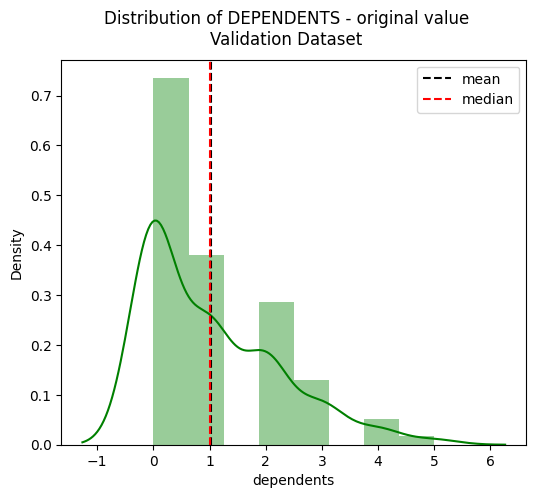

In [83]:
# Print the statistical information and histogram plot before data binning
x = df_valid['dependents']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of DEPENDENTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [84]:
# Execute the binning function
df_valid = binning(df_valid, 'dependents', config["bins_dependents"], config["labels_dependents"])

# Check the binning result and compare it with the original `dependents` value
df_valid[['dependents', 'dependents_bin']].tail(10)


,dependents,dependents_bin
175,0,0
176,3,2
177,0,0
178,0,0
179,2,2
180,3,2
181,0,0
182,0,0
183,0,0
184,0,0


count    185.000000
mean       0.886486
std        0.940098
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 1.0


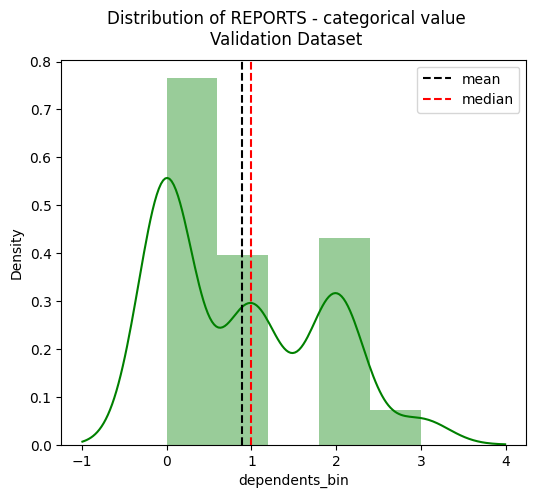

In [85]:
# Print the statistical information and histogram plot after data binning
x = df_valid['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [86]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

In [87]:
# Execute the binning function
df_test = binning(df_test, 'dependents', config["bins_dependents"], config["labels_dependents"])

# Check the binning result and compare it with the original `dependents` value
df_test[['dependents', 'dependents_bin']].tail(10)

,dependents,dependents_bin
214,3,2
215,0,0
216,0,0
217,0,0
218,0,0
219,0,0
220,2,2
221,2,2
222,2,2
223,1,1


count    224.000000
mean       0.790179
std        0.906228
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 0.0


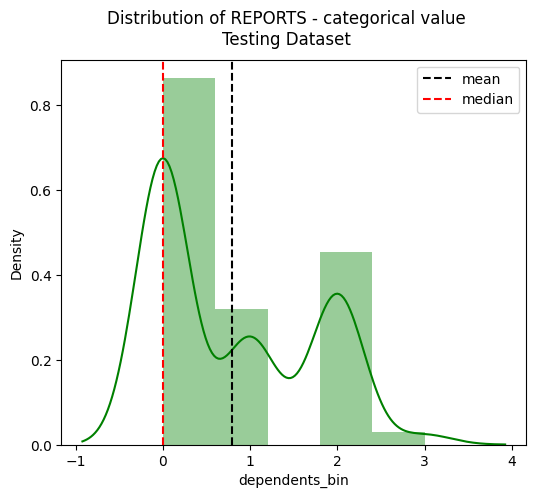

In [88]:
# Print the statistical information and histogram plot after data binning
x = df_test['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [89]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

### `active`

Based on [The New York Fed](https://www.newyorkfed.org/aboutthefed/whatwedo), average Americans have 5 - 6 active credit accounts, the detail can be read [in this link](https://www.newyorkfed.org/medialibrary/interactives/householdcredit/data/pdf/data_dictionary_HHDC.pdf) (page 2, section "Loan types").

The category definition of this feature are:
+ 0: zero active credit account
+ 1: 1 - 4 active credit accounts
+ 2: 5 - 6 active credit accounts, the typical group
+ 3: more than 6 active credit accounts

In [90]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 4, 6, 46]

# Create the instance for `reports` category labels
labels = [0, 1, 2, 3]

#### Training Data

count    903.000000
mean       6.929125
std        6.391640
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       46.000000
Name: active, dtype: float64
Median: 5.0


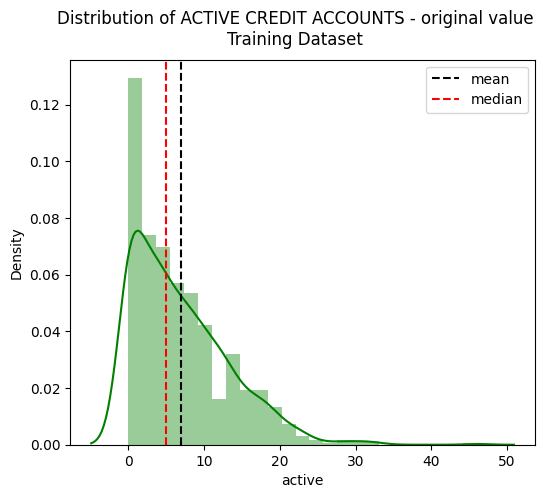

In [91]:
# Print the statistical information and histogram plot before data binning
x = df_train['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [92]:
# Execute the binning function
df_train = binning(df_train, 'active', config["bins_active"], config["labels_active"])

# Check the binning result and compare it with the original `active` value
df_train[['active', 'active_bin']].tail(10)

,active,active_bin
893,6,2
894,13,3
895,11,3
896,8,3
897,8,3
898,12,3
899,0,0
900,17,3
901,0,0
902,15,3


count    903.000000
mean       1.828350
std        1.183963
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 2.0


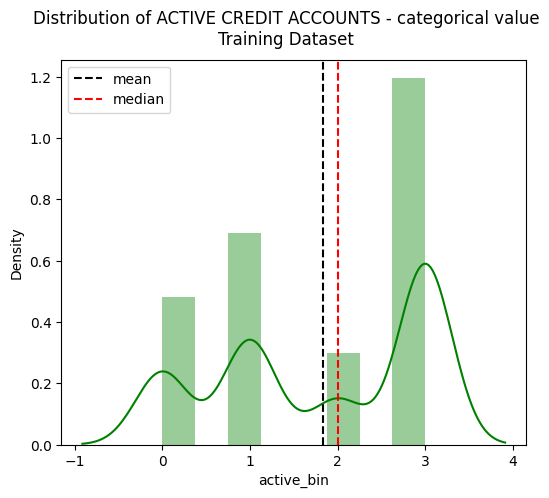

In [93]:
# Print the statistical information and histogram plot after data binning
x = df_train['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [94]:
# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

#### Validation Data

count    185.000000
mean       6.345946
std        5.701763
min        0.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       27.000000
Name: active, dtype: float64
Median: 5.0


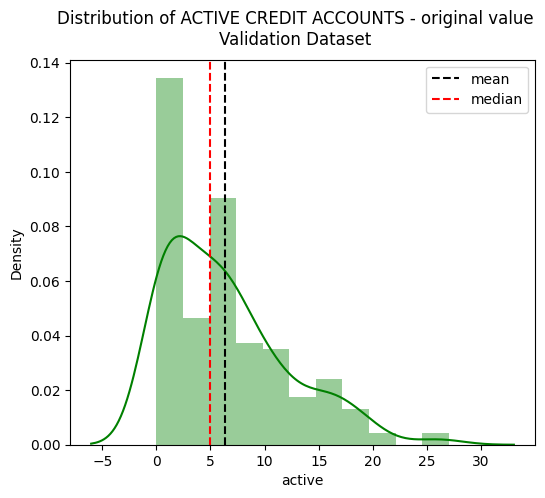

In [95]:
# Print the statistical information and histogram plot before data binning
x = df_valid['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [96]:
# Execute the binning function
df_valid = binning(df_valid, 'active', config["bins_active"], config["labels_active"])

# Check the binning result and compare it with the original `active` value
df_valid[['active', 'active_bin']].tail(10)

,active,active_bin
175,10,3
176,2,1
177,1,1
178,1,1
179,9,3
180,6,2
181,15,3
182,2,1
183,7,3
184,0,0


count    185.000000
mean       1.794595
std        1.147290
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 2.0


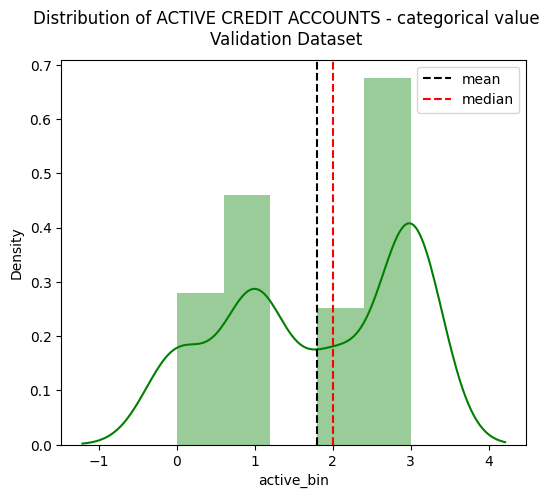

In [97]:
# Print the statistical information and histogram plot after data binning
x = df_valid['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [98]:
# Save the updated dataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

#### Testing Data

count    224.000000
mean       7.821429
std        6.426842
min        0.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       44.000000
Name: active, dtype: float64
Median: 7.0


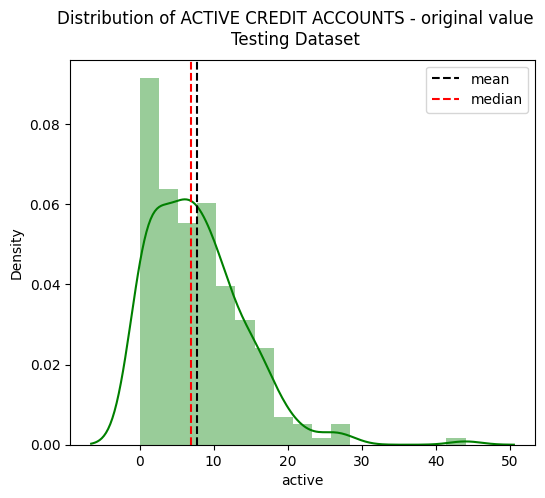

In [99]:
# Print the statistical information and histogram plot before data binning
x = df_test['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [100]:
# Execute the binning function
df_test = binning(df_test, 'active', config["bins_active"], config["labels_active"])

# Check the binning result and compare it with the original `active` value
df_test[['active', 'active_bin']].tail(10)

,active,active_bin
214,8,3
215,7,3
216,1,1
217,6,2
218,1,1
219,1,1
220,12,3
221,16,3
222,16,3
223,2,1


count    224.000000
mean       2.075893
std        1.103825
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 3.0


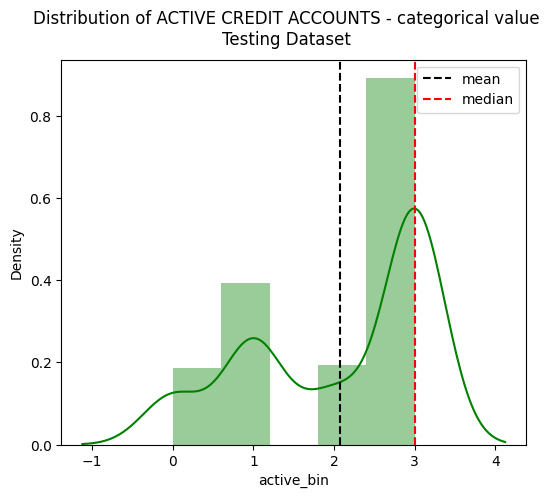

In [101]:
# Print the statistical information and histogram plot after data binning
x = df_test['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [102]:
# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

# Feature Engineering


## Value Division on the `income_log` Feature

The `income_log` feature values are annual while the `expenditure_log` feature values are monthly, and to make their values conform, I decide to divide the `income_log` feature values by 12.


In [107]:
# Create the function for value division
def division(dataset, col):
    """A function to get the monthly value from any feature in the dataset that have annual value."""

    dataset[col] = dataset[col] / 12
    return dataset

### Training Data


In [109]:
# Execute the value division function
df_train = division(df_train, 'income_log')

# Save the updated dataset
utils.pkl_dump(df_train, config["dataset_modelling_path"][0])

0      0.004371
1      0.005086
2      0.004468
3      0.004536
4      0.003555
         ...   
898    0.003193
899    0.002996
900    0.004635
901    0.005586
902    0.005353
Name: income_log, Length: 903, dtype: float64

### Validation Data 


In [105]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reports          185 non-null    int64  
 1   age              185 non-null    float64
 2   share            185 non-null    float64
 3   owner            185 non-null    int64  
 4   selfemp          185 non-null    int64  
 5   dependents       185 non-null    int64  
 6   majorcards       185 non-null    int64  
 7   active           185 non-null    int64  
 8   card             185 non-null    int64  
 9   income_log       185 non-null    float64
 10  expenditure_log  185 non-null    float64
 11  months_log       185 non-null    float64
 12  age_bin          185 non-null    int64  
 13  reports_bin      185 non-null    int64  
 14  dependents_bin   185 non-null    int64  
 15  active_bin       185 non-null    int64  
dtypes: float64(5), int64(11)
memory usage: 23.2 KB


In [110]:
# Execute the value division function
df_valid = division(df_valid, 'income_log')
# Save the updateddataset
utils.pkl_dump(df_valid, config["dataset_modelling_path"][1])

### Testing Data

In [111]:
# Execute the value division function
df_test = division(df_test, 'income_log')

# Save the updated dataset
utils.pkl_dump(df_test, config["dataset_modelling_path"][2])

## Data Balancing

The dependent variable is imbalance, it has an uneven distribution of observations.

This means that a dataset is biased towards a class in the dataset. If the dataset is biased towards one class, an algorithm trained on the same data will be biased towards the same class.

In [118]:
# Recheck the target data distribution
print(f"y_train value counts\n{df_train.card.value_counts()}")
print(f"\n--------------------------")
print(f"y_train value proportion\n{df_train.card.value_counts(normalize = True)}")

y_train value counts
1    700
0    203
Name: card, dtype: int64

--------------------------
y_train value proportion
1    0.775194
0    0.224806
Name: card, dtype: float64


Data balancing treatment will only be applied on the training dataset, there are 3 data balancing methods using the imblearn library, e.g. random undersampling, random oversampling, and SMOTE.

In [131]:
# Create the data balancing function
def balancing(dataset, 
              save_file = True,
              return_file = True):
    """A function to handle the dataset with imbalance target with various method from the imblearn library.
    x = the predictors in dataset, and y = the target in dataset,
    both method creates new x and y as data length changed,
    the new x and y dataframes are saved as pickle files"""

    y = dataset['card']
    x = dataset.drop(['card'], axis = 1)
    
    x_train_rus, y_train_rus = RandomUnderSampler(random_state = 46).fit_resample(x, y)
    x_train_ros, y_train_ros = RandomOverSampler(random_state = 85).fit_resample(x, y)
    x_train_smote, y_train_smote = SMOTE(random_state = 1205).fit_resample(x, y)

    if save_file:
        utils.pkl_dump(x_train_rus, config["dataset_train_balanced_path"][0])
        utils.pkl_dump(y_train_rus, config["dataset_train_balanced_path"][1])
        utils.pkl_dump(x_train_ros, config["dataset_train_balanced_path"][2])
        utils.pkl_dump(y_train_ros, config["dataset_train_balanced_path"][3])
        utils.pkl_dump(x_train_smote, config["dataset_train_balanced_path"][4])
        utils.pkl_dump(y_train_smote, config["dataset_train_balanced_path"][5])
        
    if return_file: 
        return x_train_rus, y_train_rus, \
               x_train_ros, y_train_ros, \
               x_train_smote, y_train_smote
    

In [132]:
# Execute the data balancing function
x_train_rus, y_train_rus, x_train_ros, y_train_ros, x_train_smote, y_train_smote = balancing(df_train)

# Check the dependent variable distribution after data balancing
print(f"balanced y_train value counts with random undersampler \n{y_train_rus.value_counts()}")
print(f"balanced y_train value counts with random oversampler \n{y_train_ros.value_counts()}")
print(f"balanced y_train value counts with SMOTE \n{y_train_smote.value_counts()}")

balanced y_train value counts with random undersampler 
0    203
1    203
Name: card, dtype: int64
balanced y_train value counts with random oversampler 
1    700
0    700
Name: card, dtype: int64
balanced y_train value counts with SMOTE 
1    700
0    700
Name: card, dtype: int64


In [ ]:
# Execute the data balancing function
x_train_rus, y_train_rus, x_train_ros, y_train_ros, x_train_smote, y_train_smote = balancing(df_train)

# Check the dependent variable distribution after data balancing
print(f"balanced y_train value counts with random undersampler \n{y_train_rus.value_counts()}")
print(f"balanced y_train value counts with random oversampler \n{y_train_ros.value_counts()}")
print(f"balanced y_train value counts with SMOTE \n{y_train_smote.value_counts()}")


balanced y_train value counts with random undersampler 
0    204
1    204
Name: card, dtype: int64
balanced y_train value counts with random oversampler 
1    700
0    700
Name: card, dtype: int64
balanced y_train value counts with SMOTE 
1    700
0    700
Name: card, dtype: int64


['/root/ml_process_feb23/data/processed/df_train_smote.pkl']